In [1]:
import pandas as pd
import statsmodels.api as sm
from patsy import dmatrices
from statsmodels.nonparametric.smoothers_lowess import lowess as  sm_lowess
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.formula.api import ols
import statsmodels.stats.api as sms
from statsmodels.compat import lzip
import matplotlib.pyplot as plt
import numpy as np
import scipy
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

senic_df = pd.read_csv('./senic_train.csv')

senic_df.head()

,infection_risk,stay_length,age,culture_ratio,chest_ratio,bed_count,med_school,nurses_per_bed,capacity_ratio,region_1,region_2,region_3,region_4
0,2.9,10.80,63.9,1.6,57.4,130,2,0.476923,0.530769,0,0,1,0
1,4.9,11.07,53.2,28.5,122.0,768,1,0.854167,0.769531,1,0,0,0
2,4.0,9.20,52.2,17.5,71.1,298,1,0.791946,0.818792,0,0,0,1
3,5.4,11.18,45.7,60.5,85.8,640,1,0.562500,0.623437,0,1,0,0
4,5.7,11.80,53.8,9.1,116.9,571,1,0.821366,0.772329,0,1,0,0


In [2]:
senic_columns = senic_df.columns

y = 'infection_risk'
x = " + ".join([i for i in senic_columns if  i != y])

In [3]:
fit = ols(y + '~' + x, 
            data=senic_df).fit()

print(fit.summary())

senic_df['resids'] = fit.resid
senic_df['sq_resids'] = fit.resid**2
stud_res = fit.outlier_test()
senic_df['studentized_resids'] = stud_res['student_resid']
senic_df['yhat'] = fit.predict()


                            OLS Regression Results                            
Dep. Variable:         infection_risk   R-squared:                       0.671
Model:                            OLS   Adj. R-squared:                  0.617
Method:                 Least Squares   F-statistic:                     12.40
Date:                Tue, 20 Apr 2021   Prob (F-statistic):           2.42e-12
Time:                        09:19:29   Log-Likelihood:                -88.680
No. Observations:                  79   AIC:                             201.4
Df Residuals:                      67   BIC:                             229.8
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -4.5936      1.458     -3.

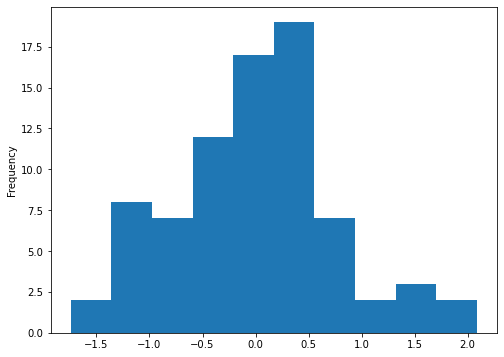

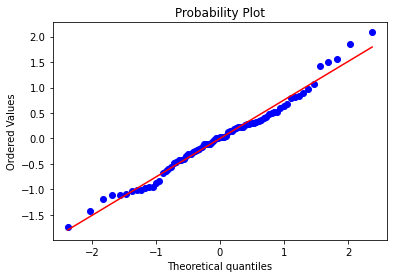

Shapiro Statistic: 0.983
Data appears to be normal with p-value: 0.394


In [328]:


def residual_plots(x, y, xlabel, ylabel, loess=True, frac=0.5):

#     plt.scatter(x, y)
    plt.axhline(y=0, color='black', linestyle='--')
    plt.xlabel(xlabel);
    plt.ylabel(ylabel);
    if loess == True:
        sm_x, sm_y = sm_lowess(y, x,  frac=frac, 
                               it=2, return_sorted = True).T
        plt.plot(sm_x, sm_y, color='tomato')
        plt.plot(x, y, 'k.')


def big_group_plot(df, var, display_n_cols, plot_cols, plot_titles, plot_type):
    
    while (len(plot_cols)%display_n_cols) != 0:
        plot_cols.append('')
        plot_titles.append('')

    display_n_rows = len(plot_cols)//display_n_cols
    plot_cols = np.array(plot_cols).reshape(display_n_rows, display_n_cols)
    plot_titles = np.array(plot_titles).reshape(display_n_rows, display_n_cols)
    
    for i in range(display_n_rows):
        for j in range(display_n_cols):
            if plot_cols[i,j] == '':
                pass
            else:
                ax = plt.subplot2grid((display_n_rows, display_n_cols), (i,j))
                if plot_type == 'dfbeta':

                    ax.scatter(x=df[var], y=df[plot_cols[i,j]].abs())
                    ax.set_title(plot_cols[i,j])
                    ax.axhline(y=1, color='black', linestyle='--');
                    
                if plot_type in ['resids', 'studentized_resids', 'sq_resids']:
                    
                    ax.axhline(y=0, color='black', linestyle='--')
                    ax.set_xlabel(plot_cols[i,j]);
                    sm_x, sm_y = sm_lowess( df[var], df[plot_cols[i,j]],  frac=0.5, 
                                           it=2, return_sorted = True).T
                    ax.plot(sm_x, sm_y, color='tomato')
                    ax.plot(df[plot_cols[i,j]], df[var], 'k.')

    plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
                        wspace=0.35)
    plt.show()
    
def normality_output(data):
    shapiro_output = stats.shapiro(data)
    shapiro_stat = shapiro_output[0]
    shapiro_p = shapiro_output[1]
    print("Shapiro Statistic: {:.3f}".format(shapiro_stat))
    if shapiro_p < 0.05:
        print('Data is non-normal with p-value: {:.5f}'.format(shapiro_p))
    else:
        print('Data appears to be normal with p-value: {:.3f}'.format(shapiro_p))
        
        
    return shapiro_output

### Test normality of residuals!

plt.figure(figsize=(8, 6))

senic_df['resids'].plot(kind='hist');

fig = plt.figure()
ax1 = fig.add_subplot(111)
prob = stats.probplot(senic_df['resids'], dist=stats.norm, plot=ax1)
plt.show();

shapiro_stats = normality_output(senic_df['resids'])




## Raw Residual Plots

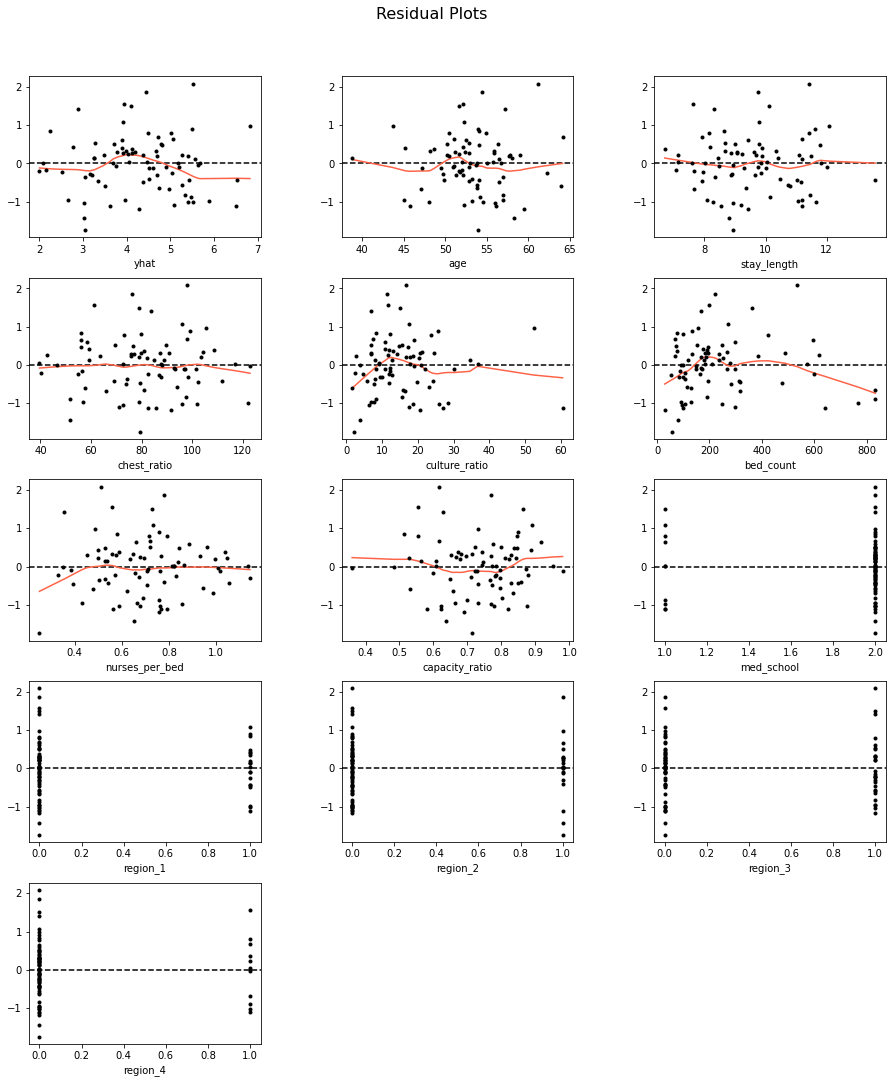

In [329]:
resid_cols = ['yhat','age','stay_length','chest_ratio','culture_ratio','bed_count',
              'nurses_per_bed','capacity_ratio','med_school','region_1','region_2',
              'region_3','region_4']

resid_cols = ['yhat','age','stay_length','chest_ratio','culture_ratio','bed_count',
              'nurses_per_bed','capacity_ratio','med_school','region_1','region_2',
              'region_3','region_4']

fig = plt.figure(figsize=(14, 16))

fig.suptitle("Residual Plots", fontsize=16)
big_group_plot(senic_df, 'resids', 3, resid_cols, resid_cols, plot_type='resids')

## Squared Residuals

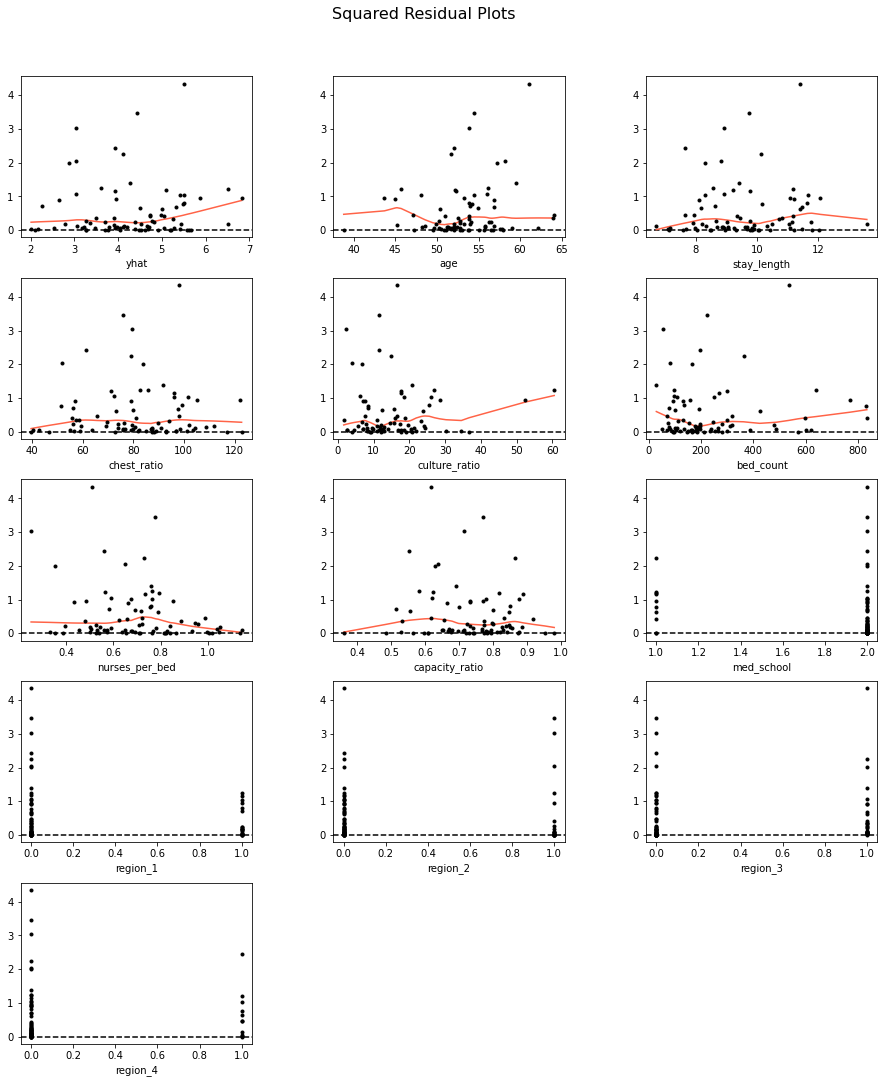

In [330]:

fig = plt.figure(figsize=(14, 16))

fig.suptitle("Squared Residual Plots", fontsize=16)
big_group_plot(senic_df, 'sq_resids', 3, resid_cols, resid_cols, plot_type='sq_resids')

## Studentized Residuals

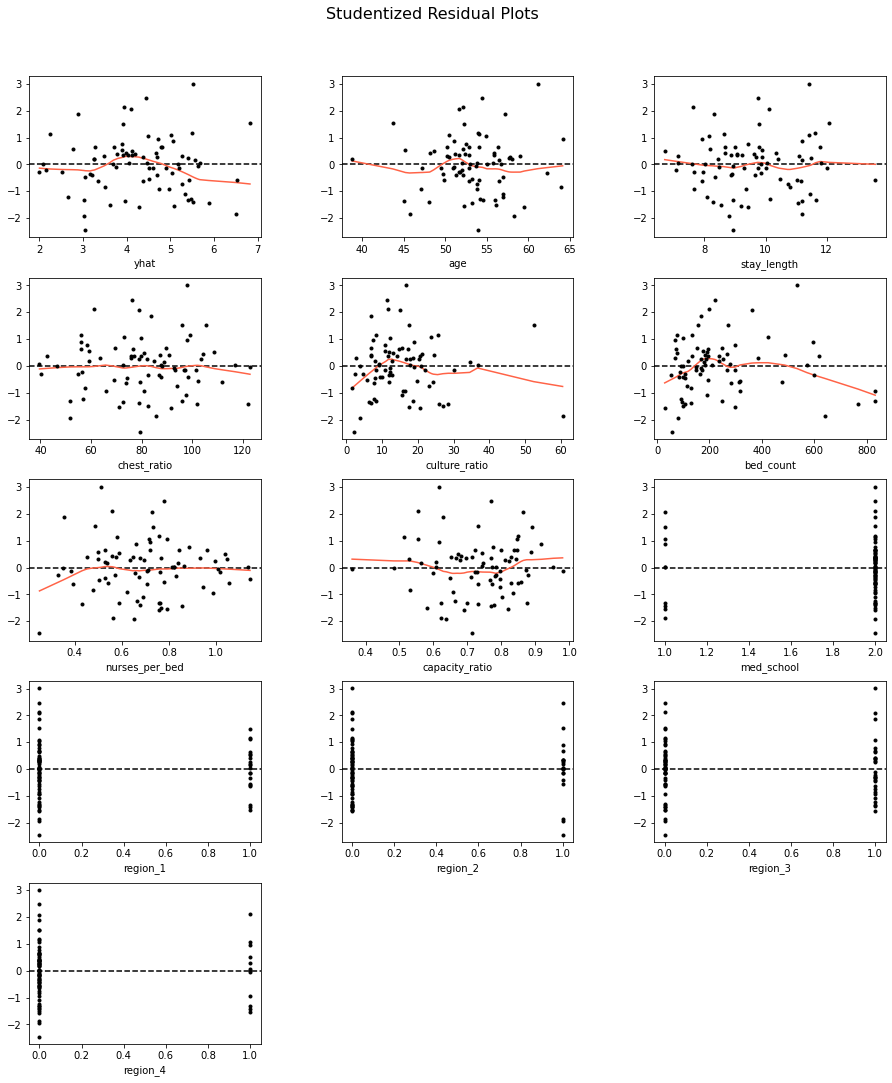

In [331]:

fig = plt.figure(figsize=(14, 16))

fig.suptitle("Studentized Residual Plots", fontsize=16)
big_group_plot(senic_df, 'studentized_resids', 3, resid_cols, resid_cols, plot_type='studentized_resids')

## Residual analysis

Some definite bowing of residuals, however I am not overly concerned regarding heteroscadascity, will perform a breusch pagan test to confirm

No outliers were noticed in the studentized residuals we are seeing some curvilinear relationships in Bed Count in the studentized residuals

## Breusch Pagan

Null Hypothesis: Homoscedasticity is present
Alternative Hypothesis: Homoscedasticity is not present

Because p > 0.05 we fail to reject the null hypothesis and conclude there is not enough evidence that heteroscadacity is present


In [8]:
#perform Bresuch-Pagan test
names = ['Lagrange multiplier statistic', 'p-value',
        'f-value', 'f p-value']
test = sms.het_breuschpagan(fit.resid, fit.model.exog)

lzip(names, test)

[('Lagrange multiplier statistic', 12.8082566045203),
 ('p-value', 0.3831301693873991),
 ('f-value', 1.1786051037371041),
 ('f p-value', 0.31861019407382624)]

## Multicollinearity

From the below there doesn't seem to be any issues of multicollinearity

In [9]:
x = " + ".join([i for i in senic_columns if  i != y and 'region_' not in i])
_, exog = dmatrices(y + '~' + x, data=senic_df, return_type='dataframe')

#calculate VIF for each explanatory variable
vif_df = pd.DataFrame()
vif_df['VIF'] = [variance_inflation_factor(exog.values, i) for i in range(exog.shape[1])]
vif_df['variable'] = exog.columns
print(vif_df.sort_values(by='VIF',ascending=False))
# anything greater than 5! is considered high VIF


          VIF        variable
0  357.559716       Intercept
1    1.749076     stay_length
3    1.675167   culture_ratio
5    1.517186       bed_count
6    1.511026      med_school
4    1.407132     chest_ratio
8    1.374083  capacity_ratio
2    1.249941             age
7    1.157050  nurses_per_bed


## Influential Diagnositics

In [149]:
def stud_del_resids_func(resids, hat_ii):
    stud_del_resids = []
    for i in range(len(hat_ii)):
        stud_del_resids.append(resids[i]/(1-hat_ii[i]))
    return stud_del_resids

def infl_y_tstat_threshold(alpha, n_obs, n_params):
    p_val = 1-alpha/(n_obs*2)
    df = n_obs-n_params-1
    t_stat = scipy.stats.t.ppf(p_val, df)
    return t_stat

def stud_del_resids_tstat_func(resids, hat_ii , sse , n_obs, n_params):
    stud_del_tstat = []
    for i in range(len(resids)):
        stud_del_tstat.append(resids[i] * np.sqrt((n_obs-n_params-1)/(sse*(1-hat_ii[i])-resids[i]**2)))
    return np.array(stud_del_tstat)

resids = np.array(fit.resid)
sse = fit.ssr
n_obs = int(fit.nobs)
n_params = len(fit.params)
infl = fit.get_influence()
sm_fr = infl.summary_frame()
hat_ii = sm_fr[['hat_diag']].values.flatten()
sm_fr.loc[:, 'stud_del_resids'] = stud_del_resids_func(resids, hat_ii)

### Influential Points for Y

We see no influential Y points!

In [336]:

stud_del_resids = stud_del_resids_func(resids, hat_ii)
t_stat_threshold = infl_y_tstat_threshold(0.05, n_obs, n_params)    
stud_del_tstat = stud_del_resids_tstat_func(resids, hat_ii, sse, n_obs, n_params)

infl_y_df = pd.DataFrame({'stud_del_resids':stud_del_resids, 'stud_del_tstat':stud_del_tstat})
infl_y_df['influential'] = infl_y_df['stud_del_tstat'].abs()>t_stat_threshold
infl_y_df.loc[infl_y_df['influential']==True]

infl_y_df = infl_y_df.sort_values(by='stud_del_resids', key=abs, ascending=False)
infl_y_df.head()

,stud_del_resids,stud_del_tstat,influential
55,2.529649,2.988281,False
76,-2.089501,-2.430720,False
63,1.985310,2.450879,False
3,-1.971006,-1.850811,False
26,1.791678,2.108728,False


### Influential points in X

Leverage points in X-values far from the bulk of the data. We do see two points here

0.329


,hat_diag,leverage_point
3,0.437265,True
59,0.370714,True
28,0.322390,False
11,0.296136,False
4,0.279022,False


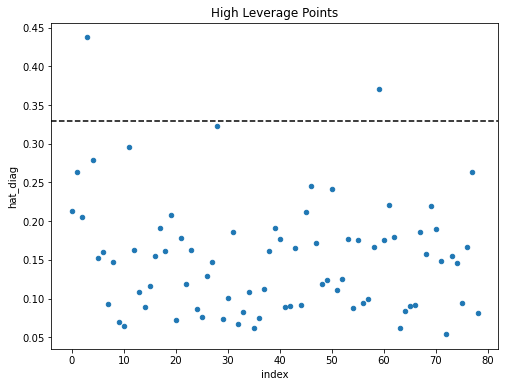

In [337]:
# looking for leverage points

sm_fr['leverage_point'] = sm_fr['hat_diag'] > (2*n_params)/n_obs
print(round((2*n_params)/n_obs, 3))
plt.figure(figsize=(8, 6))
ax = plt.subplot(111);
sm_fr.plot(kind='scatter', x='index', y='hat_diag', ax=ax).set_title('High Leverage Points');
plt.axhline(y=(2*n_params)/n_obs, color='black', linestyle='--');
sm_fr[['hat_diag','leverage_point']].sort_values(by='hat_diag', ascending=False).head()

### Influential points in prediction

We see no influential points in Cook's D but we do see four points in DFFITS. Because our research question is not prediction, we will weight these outcomes less. 

,cooks_d,cooks_f_p,cooks_f_threshold
3,0.200484,0.001342,0.958912
55,0.132707,0.000142,0.958912
59,0.104979,0.000037,0.958912
76,0.085839,0.000011,0.958912
23,0.061675,0.000002,0.958912


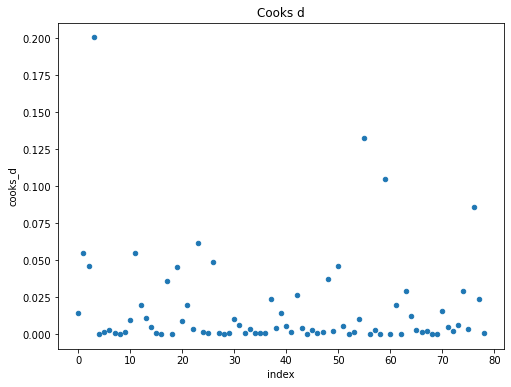

In [338]:
# Cooks d

cooks_f_threshold = stats.f.ppf(0.5, n_params, n_obs-n_params)
sm_fr['cooks_f_threshold'] = cooks_f_threshold

sm_fr['cooks_f_p'] = sm_fr['cooks_d'].apply(lambda x: stats.f.cdf(x, n_params, n_obs-n_params))

cooks_df = sm_fr[['index','cooks_d', 'cooks_f_p','cooks_f_threshold']].sort_values(by='cooks_d', ascending=False)
plt.figure(figsize=(8, 6))
ax = plt.subplot(111);
cooks_df.plot(kind='scatter', x='index', y='cooks_d', ax=ax).set_title('Cooks d');
# plt.axhline(y=cooks_f_threshold, color='black', linestyle='--');
cooks_df[['cooks_d','cooks_f_p','cooks_f_threshold']].head()

,abs_dffits,dffits_above_thresh
3,1.643986,True
55,1.390293,True
59,1.180046,True
76,1.095066,True
23,0.917359,False
1,0.851373,False
11,0.845799,False
26,0.817571,False
2,0.778958,False
50,0.775686,False


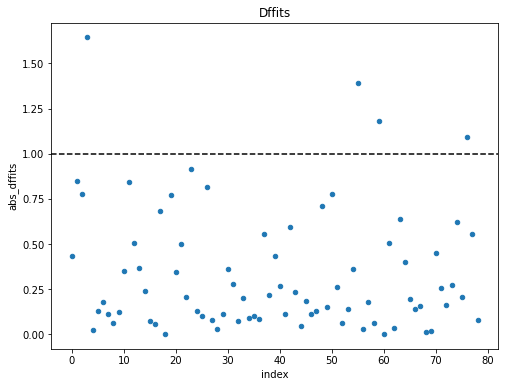

In [212]:
#dffits

dffits_df = sm_fr[['index', 'dffits']]
dffits_df['abs_dffits'] = dffits_df['dffits'].abs()
dffits_df['dffits_above_thresh'] = dffits_df['abs_dffits']>1
dffits_df = dffits_df.sort_values(by='abs_dffits', ascending=False)

plt.figure(figsize=(8, 6))
ax = plt.subplot(111);
dffits_df.plot(kind='scatter', x='index', y='abs_dffits', ax=ax).set_title('Dffits');
plt.axhline(y=1, color='black', linestyle='--');
dffits_df[['abs_dffits','dffits_above_thresh']].head(10)

### DFBETAS Influential points for explanation

We see one point in dfb_culture_ratio that is above the threshold. Again we see that it is point 3.


    dfb_culture_ratio
3           -1.154436
59           0.743313
50           0.310909
74          -0.281823
76           0.252322


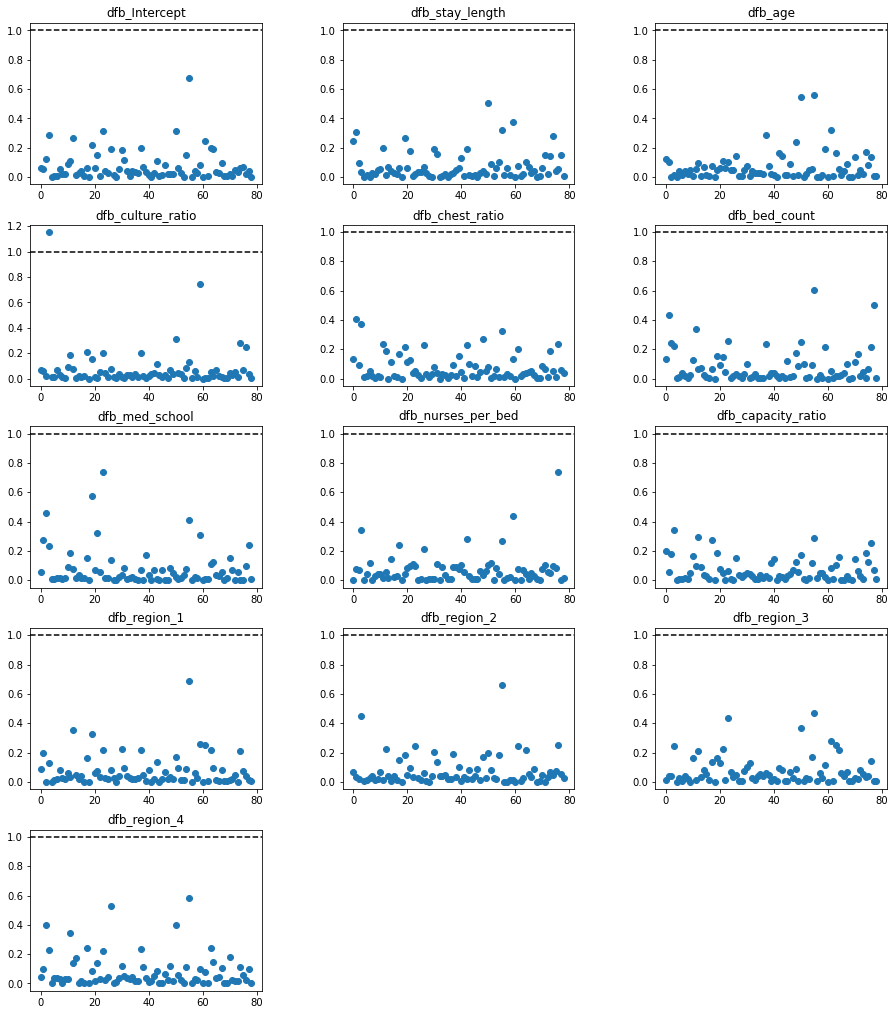

In [346]:
#dfb
param_names = fit.params.index
dfb_cols = ['dfb_'+i for i in param_names]
dfb_df = sm_fr.loc[:,['index']+dfb_cols].copy()
print(dfb_df.sort_values(by='dfb_culture_ratio', key=abs, ascending=False)[['dfb_culture_ratio']].head())
plt.figure(figsize=(14, 16))
big_group_plot(dfb_df, 'index', 3, dfb_cols, dfb_cols, plot_type='dfbeta')



,index,dfb_Intercept,dfb_stay_length,dfb_age,dfb_culture_ratio,dfb_chest_ratio,dfb_bed_count,dfb_med_school,dfb_nurses_per_bed,dfb_capacity_ratio,dfb_region_1,dfb_region_2,dfb_region_3,dfb_region_4
0,0,0.060406,-0.248106,-0.123578,0.068319,0.133182,0.131379,0.057343,0.005110,0.197579,0.087454,0.068663,0.009760,0.046982
1,1,-0.056120,0.307374,-0.100260,0.060251,-0.409694,-0.432054,0.272134,-0.079352,0.058239,-0.199560,-0.036697,-0.037367,0.098713
2,2,-0.122881,-0.093047,-0.003369,0.017618,0.094325,0.242142,0.460521,0.066946,-0.176692,0.001499,-0.020721,-0.040250,-0.401929
3,3,-0.287576,0.033941,0.016492,-1.154436,0.375935,-0.220777,0.230481,0.343194,0.343639,-0.128282,-0.447109,-0.243267,-0.225955
4,4,0.001169,0.002771,0.000552,-0.011672,0.011033,0.001606,-0.011331,0.002682,-0.002830,-0.000329,0.004482,0.000757,-0.000488
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74,74,-0.059366,0.280251,-0.174420,-0.281823,0.052966,0.007916,0.002456,-0.097672,0.188025,-0.209913,-0.050837,-0.035264,0.110360
75,75,-0.070395,-0.038650,0.082710,0.065954,0.008755,-0.066291,-0.001130,-0.084505,0.124936,-0.077233,-0.073301,-0.038847,-0.060334
76,76,-0.019484,0.055816,-0.135164,0.252322,-0.239665,0.217494,0.097517,0.736296,-0.253258,0.042913,-0.252883,0.142372,-0.027206
77,77,0.044361,0.149097,-0.004879,-0.037555,-0.061730,-0.502120,-0.241987,-0.002427,0.071300,0.014640,0.054544,-0.003378,0.099951
